In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
usage_df = pd.read_csv('kings_c.csv')

In [3]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
0,93202,Kings County,1,2015,Residential,588051.0,0.588051
1,93202,Kings County,1,2015,Commercial,139871.0,0.139871
2,93212,Kings County,1,2015,Agricultural,1715714.0,1.715714
3,93230,Kings County,1,2015,Residential,12618684.0,12.618684
4,93230,Kings County,1,2015,Commercial,8272566.0,8.272566


In [4]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ZipCode        631 non-null    int64  
 1   County         631 non-null    object 
 2   Month          631 non-null    int64  
 3   Year           631 non-null    int64  
 4   CustomerClass  631 non-null    object 
 5   TotalkWh       631 non-null    float64
 6   TotalGWh       631 non-null    float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ KB


In [5]:
# Creating GWh field from converting kWh
usage_df['TotalGWh'] = usage_df['TotalkWh'] / 1000000

In [6]:
# Creating 'Date' column to combine Month and Year
usage_df['Date'] = usage_df['Month'].astype(str) + '-' + usage_df['Year'].astype(str)

In [7]:
usage_df['Date'] = pd.to_datetime(usage_df['Date'], format='%m-%Y')

In [8]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ZipCode        631 non-null    int64         
 1   County         631 non-null    object        
 2   Month          631 non-null    int64         
 3   Year           631 non-null    int64         
 4   CustomerClass  631 non-null    object        
 5   TotalkWh       631 non-null    float64       
 6   TotalGWh       631 non-null    float64       
 7   Date           631 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 39.6+ KB


In [9]:
# Setting 'Date' as the index
usage_df = usage_df.set_index('Date')

In [10]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
Date,,,,,,,
2015-01-01,93202,Kings County,1,2015,Residential,588051.0,0.588051
2015-01-01,93202,Kings County,1,2015,Commercial,139871.0,0.139871
2015-01-01,93212,Kings County,1,2015,Agricultural,1715714.0,1.715714
2015-01-01,93230,Kings County,1,2015,Residential,12618684.0,12.618684
2015-01-01,93230,Kings County,1,2015,Commercial,8272566.0,8.272566


## Resampling dataframe to total monthly usage

In [11]:
usage = usage_df[['TotalkWh','TotalGWh']].resample('M').sum()

In [12]:
usage.head()

,TotalkWh,TotalGWh
Date,,
2015-01-31,27477871.0,27.477871
2015-02-28,28010833.0,28.010833
2015-03-31,27059538.0,27.059538
2015-04-30,31276628.0,31.276628
2015-05-31,32048165.0,32.048165


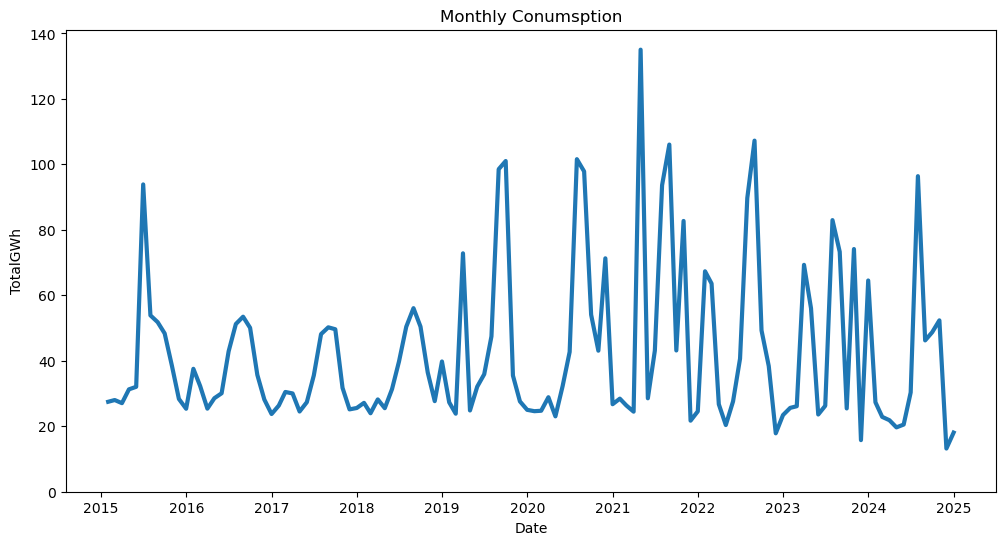

In [13]:
# PLotting data
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], linewidth=3)
plt.title("Monthly Conumsption")
plt.xlabel("Date")
plt.ylabel("TotalGWh")
plt.ylim(ymin=0)
plt.show()

## Implementing SARIMA model

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
# Checking for stationarity of data

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
 
 
check_stationarity(usage['TotalGWh'])

ADF Statistic: -1.077010119704509
p-value: 0.7241523970149015
Non-Stationary


***SARIMAX model can still handle non-stationary data***

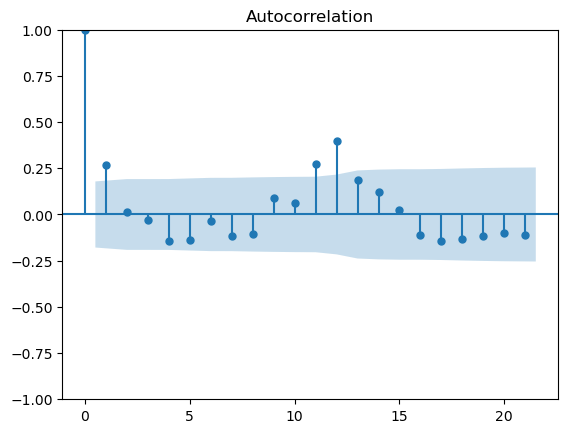

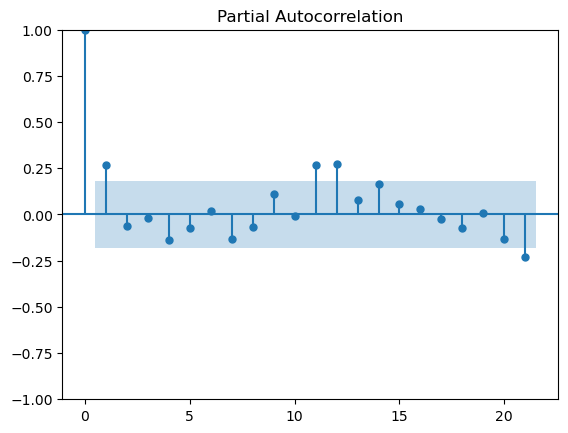

In [16]:
 # Plot ACF and PACF
plot_acf(usage['TotalGWh'])
plot_pacf(usage['TotalGWh'])
plt.show()

## Using AutoArima to find the parameters for SARIMAX model

In [17]:
# Install the library if necessary
# !pip install pmdarima

# Import the library
from pmdarima.arima import auto_arima

# Build and fit the AutoARIMA model
model = auto_arima(usage['TotalGWh'],
                   test='adf',
                   seasonal=True,
                   #max_p=3, max_q=3,
                   start_p=0,
                   d=1,
                   trace=True,
                   start_P=0,
                   m=12,
                   #D=None,
                   stepwise=True,
                   with_intercept=True,
                   suppress_warnings=True)

model.fit(usage['TotalGWh'])

# Check the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1144.365, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1124.378, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1142.366, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1132.932, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1118.558, Time=0.19 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1119.500, Time=0.34 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1118.840, Time=0.11 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1139.105, Time=0.12 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=1105.457, Time=0.25 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1116.472, Time=0.08 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=1105.386, Time=0.43 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=1106.292, Time=0.21 sec
 ARIMA(2,1,0)(2,0,2)[12] inte

In [18]:
# p, d, q parameters
model.order

(3, 1, 1)

In [19]:
# P, D, Q, s parameters
model.seasonal_order

(1, 0, 1, 12)

In [20]:
# Define SARIMA parameters from AutoArima results

# Fit the SARIMA model
model = SARIMAX(usage['TotalGWh'], order=model.order, seasonal_order=model.seasonal_order)
results = model.fit()
model

C:\Users\adamc\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Forecasting the next 12 months

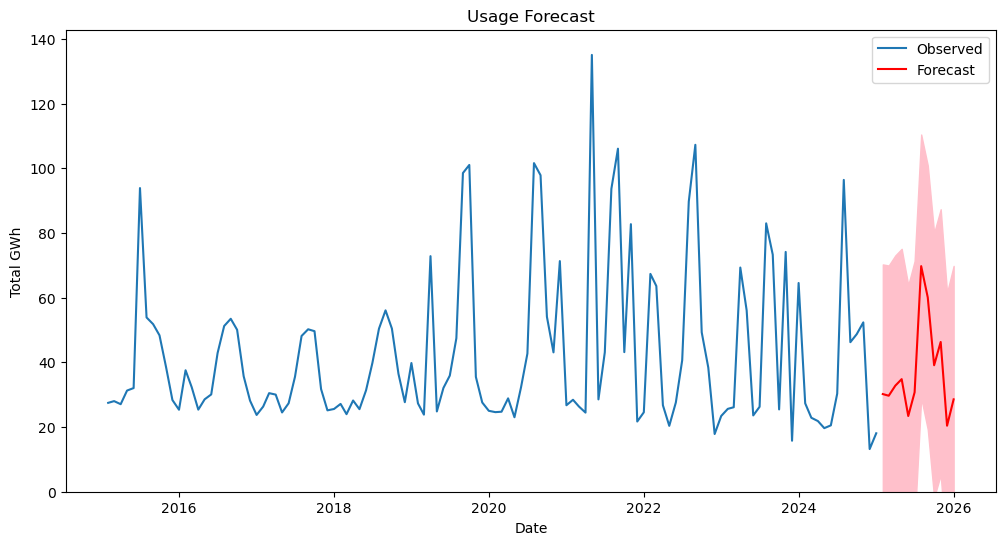

In [21]:
# Forecast future demand
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

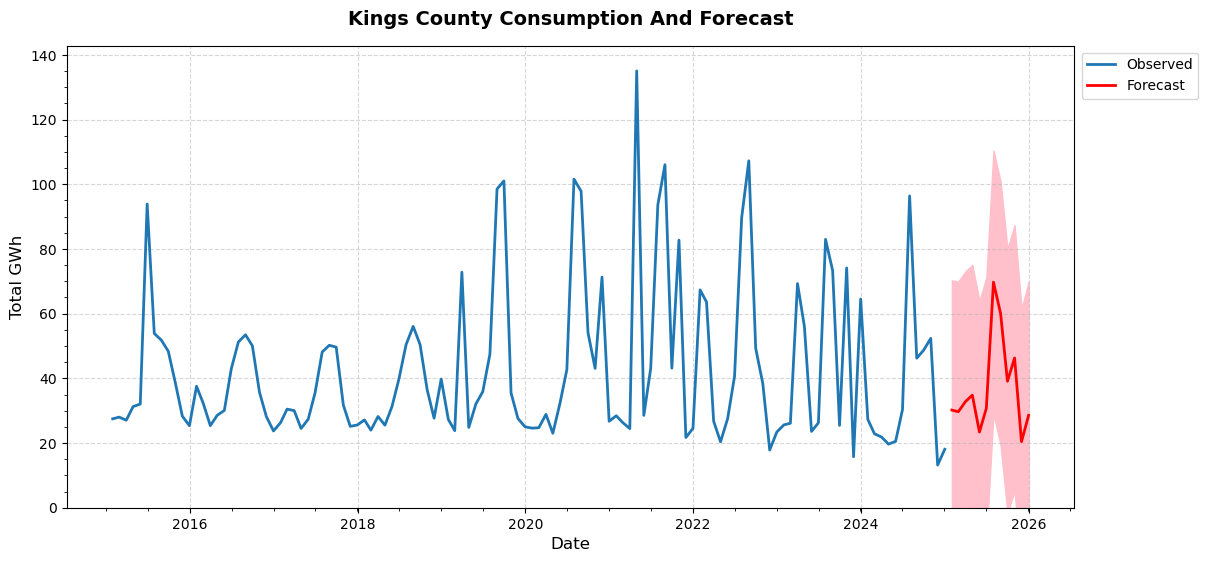

In [22]:
# Alternative Plot
from matplotlib.ticker import AutoMinorLocator


# Plot settings
plt.figure(figsize=(13, 6))
ax1 = sns.lineplot(data=usage['TotalGWh'], label='Observed',linewidth=2)
ax2 = sns.lineplot(data=forecast_mean, label='Forecast', color='red', linewidth=2)

# Fill between forecast confidence intervals
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')


# Plot labels and legend
plt.title("Kings County Consumption And Forecast", weight='bold', fontsize=14, pad=15)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Total GWh",fontsize=12)
plt.ylim(bottom=0)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.13,1), loc='upper right')

# Show plot
#plt.savefig('kings_c.png')
plt.show()

### Evaluate Model

In [23]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 9.412737600080819
MSE: 133.8419583861354
RMSE: 11.569008530817815


In [24]:
observed

Date
2024-01-31    27.328543
2024-02-29    22.862823
2024-03-31    21.843961
2024-04-30    19.656348
2024-05-31    20.519324
2024-06-30    30.329742
2024-07-31    96.402541
2024-08-31    46.230916
2024-09-30    48.707592
2024-10-31    52.353485
2024-11-30    13.189138
2024-12-31    18.065478
Freq: M, Name: TotalGWh, dtype: float64

In [25]:
forecast_mean

2025-01-31    30.189700
2025-02-28    29.681157
2025-03-31    32.788908
2025-04-30    34.807305
2025-05-31    23.407539
2025-06-30    30.742121
2025-07-31    69.742449
2025-08-31    60.075647
2025-09-30    39.100574
2025-10-31    46.303288
2025-11-30    20.414353
2025-12-31    28.555087
Freq: M, Name: predicted_mean, dtype: float64

### Forecasting the next 24 months

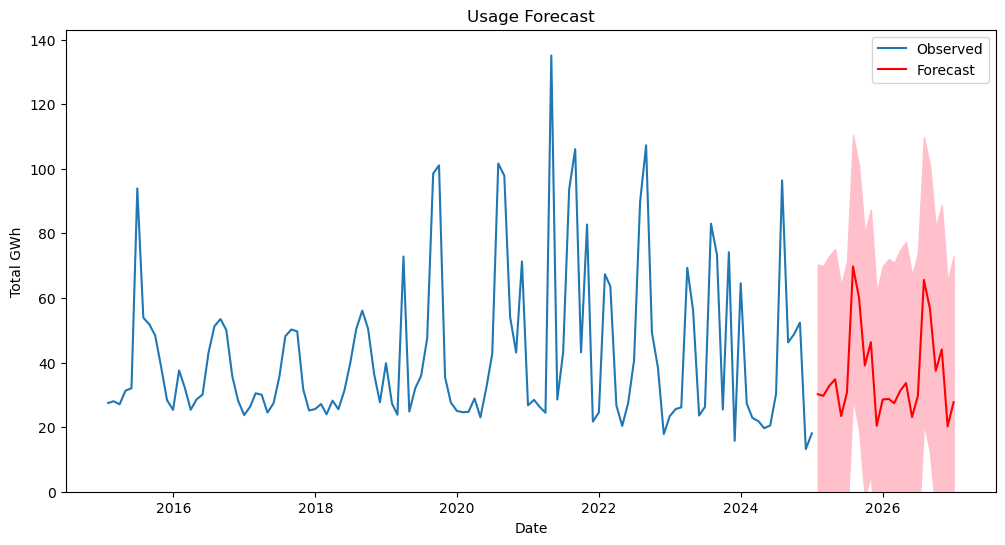

In [26]:
# Forecast future demand
forecast_periods = 24  # Forecast the next 24 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

### Evaluate Model

In [27]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 12.051280338397069
MSE: 257.45990939413423
RMSE: 16.04555731017574


In [28]:
observed

Date
2023-01-31    25.617072
2023-02-28    26.117265
2023-03-31    69.308697
2023-04-30    56.041117
2023-05-31    23.588529
2023-06-30    26.258823
2023-07-31    82.971173
2023-08-31    73.294641
2023-09-30    25.443634
2023-10-31    74.138324
2023-11-30    15.763431
2023-12-31    64.530898
2024-01-31    27.328543
2024-02-29    22.862823
2024-03-31    21.843961
2024-04-30    19.656348
2024-05-31    20.519324
2024-06-30    30.329742
2024-07-31    96.402541
2024-08-31    46.230916
2024-09-30    48.707592
2024-10-31    52.353485
2024-11-30    13.189138
2024-12-31    18.065478
Freq: M, Name: TotalGWh, dtype: float64

In [29]:
forecast_mean

2025-01-31    30.189700
2025-02-28    29.681157
2025-03-31    32.788908
2025-04-30    34.807305
2025-05-31    23.407539
2025-06-30    30.742121
2025-07-31    69.742449
2025-08-31    60.075647
2025-09-30    39.100574
2025-10-31    46.303288
2025-11-30    20.414353
2025-12-31    28.555087
2026-01-31    28.727473
2026-02-28    27.403906
2026-03-31    31.248074
2026-04-30    33.630339
2026-05-31    23.090361
2026-06-30    29.735691
2026-07-31    65.557008
2026-08-31    56.686766
2026-09-30    37.418845
2026-10-31    44.036505
2026-11-30    20.247059
2026-12-31    27.727136
Freq: M, Name: predicted_mean, dtype: float64

In [30]:
customer_consum = usage_df.groupby('CustomerClass')['TotalGWh'].sum()
customer_consum

CustomerClass
Agricultural    1110.950856
Commercial      1087.912533
Industrial      1085.588485
Residential     1815.470624
Name: TotalGWh, dtype: float64

In [31]:
customer_df = customer_consum.reset_index()
customer_df

,CustomerClass,TotalGWh
0,Agricultural,1110.950856
1,Commercial,1087.912533
2,Industrial,1085.588485
3,Residential,1815.470624


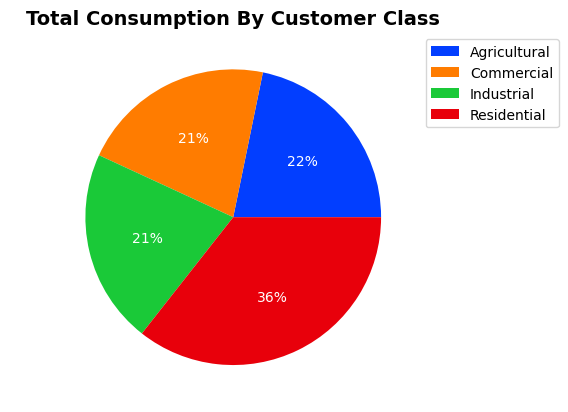

In [32]:

# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass']
       ,colors=palette_color, autopct='%.0f%%', textprops=dict(color='w'))
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()

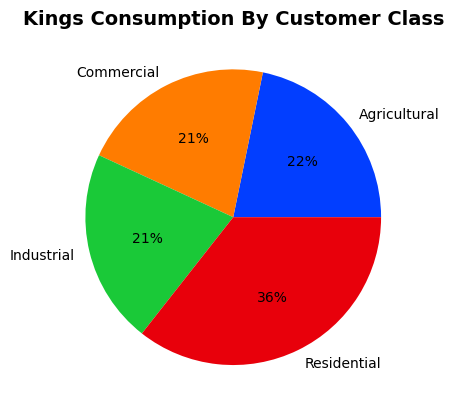

In [33]:
# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'],labels=customer_df['CustomerClass'],colors=palette_color, autopct='%.0f%%', textprops=dict(color='black'))
plt.title('Kings Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
#plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()